# Annotation

## Settings 

In [28]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed'
test = 'all'

# Gene annotation
GTF_PATH = "/mnt/flatfiles/organisms/new_organism/mus_musculus/104/mus_musculus.104.genes.gtf"
ENSEMBL_DATASET = "mmusculus_gene_ensembl" # This is used for replaceing ensembl gene IDs with gene names if possible
                                           # use "hsapiens_gene_ensembl" for homo sapiens
# Cell type annotation
SPECIES = "Mm" # Currently only Hs (Homo Sapiens) and Mm (Mus Musculus) are available for custom cell type annotation
SCSA_SPECIES = None # Currently only human (Homo Sapiens) and mouse (Mus Musculus) are available for SCSA
                    # None if using a custom DB file
# Optional custom database for SCSA
SCSA_CUSTOM_DB_PATH = "/mnt/workspace/mkessle/projects/marker_repo/dbs/mouse/panglao_all_mandatory_2020"
# Path to panglao markers
PANGLAO_DB_PATH = "/mnt/workspace/jdetlef/panglao_markers"

# The clustering resolutions which will be annotated
RESOLUTIONS = "leiden_0.4" # Choose "None" to keep the selected clustering resolution from the previous notebook
                           # You can also choose a column which contains the clustering information in the obs table
                           # It is also possible to add more than one column (resolutions) by using a list of columns
        
MODIFY_CELL_TYPES = False # If true you get the opportunity to manually modify the automatic annotated cell types

# Save figures
save_figs = True

## Loading packages and setup

In [29]:
import sctoolbox.atac_tree as sub_tree
import sctoolbox.annotation as annot
import sctoolbox.custom_celltype_annotation as ctannot
from sctoolbox.celltype_annotation import run_scsa
import pandas as pd
import episcanpy as epi
import scanpy as sc
from matplotlib import pyplot as plt
from pybiomart import Dataset
import os
import shutil

## Check files 

In [30]:
files = [GTF_PATH, SCSA_CUSTOM_DB_PATH, PANGLAO_DB_PATH]
for file in files:
    if os.path.isfile(file):
        print(f"{file} exists.")
    else:
        print(f"Please make sure that your input is correct. {file} does not exist.")

/mnt/flatfiles/organisms/new_organism/mus_musculus/104/mus_musculus.104.genes.gtf exists.
/mnt/workspace/mkessle/projects/marker_repo/dbs/mouse/panglao_all_mandatory_2020 exists.
/mnt/workspace/jdetlef/panglao_markers exists.


## Setup path handling object 

In [31]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


In [32]:
tree.gtf_path = GTF_PATH

## Load anndata

In [33]:
clustering_output = tree.clustering_anndata
adata = epi.read_h5ad(clustering_output)
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,highly_variable
chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,374,178,0.003302,0.003296,99.669838,178.0,5.187386,178,274.0,True
chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,477,3944,0.073155,0.070603,92.684510,3944.0,8.280204,3944,7932.0,False
chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,285,967,0.017936,0.017777,98.206370,967.0,6.875232,967,1788.0,True
chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,256,128,0.002374,0.002371,99.762580,128.0,4.859812,128,289.0,True
chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,233,492,0.009126,0.009084,99.087419,492.0,6.200509,492,1040.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,266,1044,0.019365,0.019179,98.063547,1044.0,6.951772,1044,2128.0,True
chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,247,287,0.005323,0.005309,99.467661,287.0,5.662961,287,521.0,True
chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,402,273,0.005064,0.005051,99.493629,273.0,5.613128,273,507.0,True
chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,221,158,0.002931,0.002926,99.706935,158.0,5.068904,158,229.0,True


In [34]:
if RESOLUTIONS:
    if type(RESOLUTIONS) == str:
        RESOLUTIONS = [RESOLUTIONS]
else:
    RESOLUTIONS = adata.uns['infoprocess']['leiden_res']

## Check columns

In [35]:
for column in RESOLUTIONS:
    if column in adata.obs:
        print(f"The obs table contains the column {column}.")
    else:
        print(f"{column} was not found in the obs table. Please pick a valid column instead.")

The obs table contains the column leiden_0.4.


In [36]:
# FIX FOR THE EXT442
adata.var['peak_chr'] = adata.var['peak_chr'].astype(str)
adata.var['peak_start'] = adata.var['peak_start'].astype(int)
adata.var['peak_end'] = adata.var['peak_end'].astype(int)

In [37]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,highly_variable
chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,374,178,0.003302,0.003296,99.669838,178.0,5.187386,178,274.0,True
chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,477,3944,0.073155,0.070603,92.684510,3944.0,8.280204,3944,7932.0,False
chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,285,967,0.017936,0.017777,98.206370,967.0,6.875232,967,1788.0,True
chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,256,128,0.002374,0.002371,99.762580,128.0,4.859812,128,289.0,True
chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,233,492,0.009126,0.009084,99.087419,492.0,6.200509,492,1040.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,266,1044,0.019365,0.019179,98.063547,1044.0,6.951772,1044,2128.0,True
chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,247,287,0.005323,0.005309,99.467661,287.0,5.662961,287,521.0,True
chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,402,273,0.005064,0.005051,99.493629,273.0,5.613128,273,507.0,True
chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,221,158,0.002931,0.002926,99.706935,158.0,5.068904,158,229.0,True


## Gene annotation 

In [38]:
annot.annotate_adata(adata,
                   GTF_PATH,
                   config=None,
                   best=True,
                   threads=6,
                   coordinate_cols=None,
                   temp_dir="",
                   verbose=True,
                   inplace=True)

Setting up annotation configuration...
Config dictionary: {'queries': [{'distance': [10000, 1000], 'feature_anchor': ['start'], 'feature': ['gene'], 'name': 'promoters'}], 'priority': True, 'show_attributes': ['all'], 'output_by_query': False}
Setting up genomic regions to annotate...
Index(['peak_chr', 'peak_start', 'peak_end'], dtype='object')
Preparing gtf file for annotation...
- Reading gtf with Tabix
- Index of gtf not found - trying to index gtf
- Reading gtf with Tabix
Done preparing gtf!
Annotating regions...
Formatting annotations...
These columns will be overwritten by the annotation
Finished annotation of features! The results are found in the .var table.
[Errno 2] No such file or directory: ''


In [39]:
adata.var['gene_name']

chr1:3050427-3050801            NaN
chr4:129518038-129518515    Ccdc28b
chr4:129518849-129519134    Ccdc28b
chr4:129527627-129527883        NaN
chr4:129533947-129534180      Txlna
                             ...   
chr4:129517580-129517846    Ccdc28b
chr1:192477325-192477572        NaN
chr1:37026210-37026612          NaN
chr1:7849890-7850111            NaN
chr1:3191548-3191937            NaN
Name: gene_name, Length: 145907, dtype: category
Categories (25284, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s162', 'n-R5s41']

In [40]:
assigned_features = adata.var['gene_name'].dropna()
assigned_features

chr4:129518038-129518515    Ccdc28b
chr4:129518849-129519134    Ccdc28b
chr4:129533947-129534180      Txlna
chr4:129534299-129535110      Txlna
chr4:129539961-129540183      Txlna
                             ...   
chr4:129502294-129503161      Eif3i
chr4:129503825-129504508      Eif3i
chr4:129512576-129513315       Iqcc
chr4:129515107-129515508       Iqcc
chr4:129517580-129517846    Ccdc28b
Name: gene_name, Length: 44074, dtype: category
Categories (25284, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s162', 'n-R5s41']

### Replace ensembl gene IDs with gene names if possible

In [41]:
dataset = Dataset(name=ENSEMBL_DATASET,
                  host='http://www.ensembl.org')

df = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])

In [42]:
ens_dict = dict(zip(df['Gene stable ID'], df['Gene name']))

In [43]:
count = 0
for index, gene in enumerate(assigned_features):
    if gene.startswith("ENSG"):
        if gene in ens_dict.keys():
            if isinstance(ens_dict[gene], str):
                assigned_features.replace(gene, ens_dict[gene], inplace=True)
                count += 1
print(f'{count} ensembl gene ids have been replaced with gene names')

0 ensembl gene ids have been replaced with gene names


In [44]:
assigned_features

chr4:129518038-129518515    Ccdc28b
chr4:129518849-129519134    Ccdc28b
chr4:129533947-129534180      Txlna
chr4:129534299-129535110      Txlna
chr4:129539961-129540183      Txlna
                             ...   
chr4:129502294-129503161      Eif3i
chr4:129503825-129504508      Eif3i
chr4:129512576-129513315       Iqcc
chr4:129515107-129515508       Iqcc
chr4:129517580-129517846    Ccdc28b
Name: gene_name, Length: 44074, dtype: category
Categories (25284, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s162', 'n-R5s41']

In [45]:
assigned_adata = adata[:, assigned_features.index]
assigned_adata

View of AnnData object with n_obs × n_vars = 53913 × 44074
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_fragments_in_promoters', 'n_total_fragments', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features', 'leiden', 'LISI_score_X_pca', 'LISI_score_X_umap', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'clustering'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand

## Rank peaks

In [46]:
peaks_adata = assigned_adata.copy()

In [47]:
peaks_adata.uns['log1p']['base'] = None

KeyError: 'log1p'

In [48]:
for column in RESOLUTIONS:
    print(f'Ranking peaks for clusters using obs column {column}')
    epi.tl.rank_features(peaks_adata, f'{column}', omic='ATAC', 
                         key_added=f'rank_features_groups_{column}', n_features=100, use_raw=False)
    
print('Done')

Ranking peaks for clusters using obs column leiden_0.4
Done


## Rank genes
Replace peaks with gene names

In [49]:
genes_adata = peaks_adata.copy()
genes_adata.var.reset_index(inplace=True)  # remove peaks from index and save them in the column ['index']
genes_adata.var.set_index('gene_name',inplace=True)  # set genes as index
genes_adata.var.index = genes_adata.var.index.astype('str')  # to avoid index being categorical
genes_adata.var_names_make_unique(join='_')
genes_adata.raw = genes_adata

In [50]:
for column in RESOLUTIONS:
    print(f'Ranking genes groups for clusters using obs column {column}')
    sc.tl.rank_genes_groups(genes_adata, groupby=f'{column}', use_raw=False, key_added=f'rank_genes_groups_{column}')
    
print('Done')

Ranking genes groups for clusters using obs column leiden_0.4
Done


### Plot ranked genes

Plotting ranked genes groups for clustering column leiden_0.4


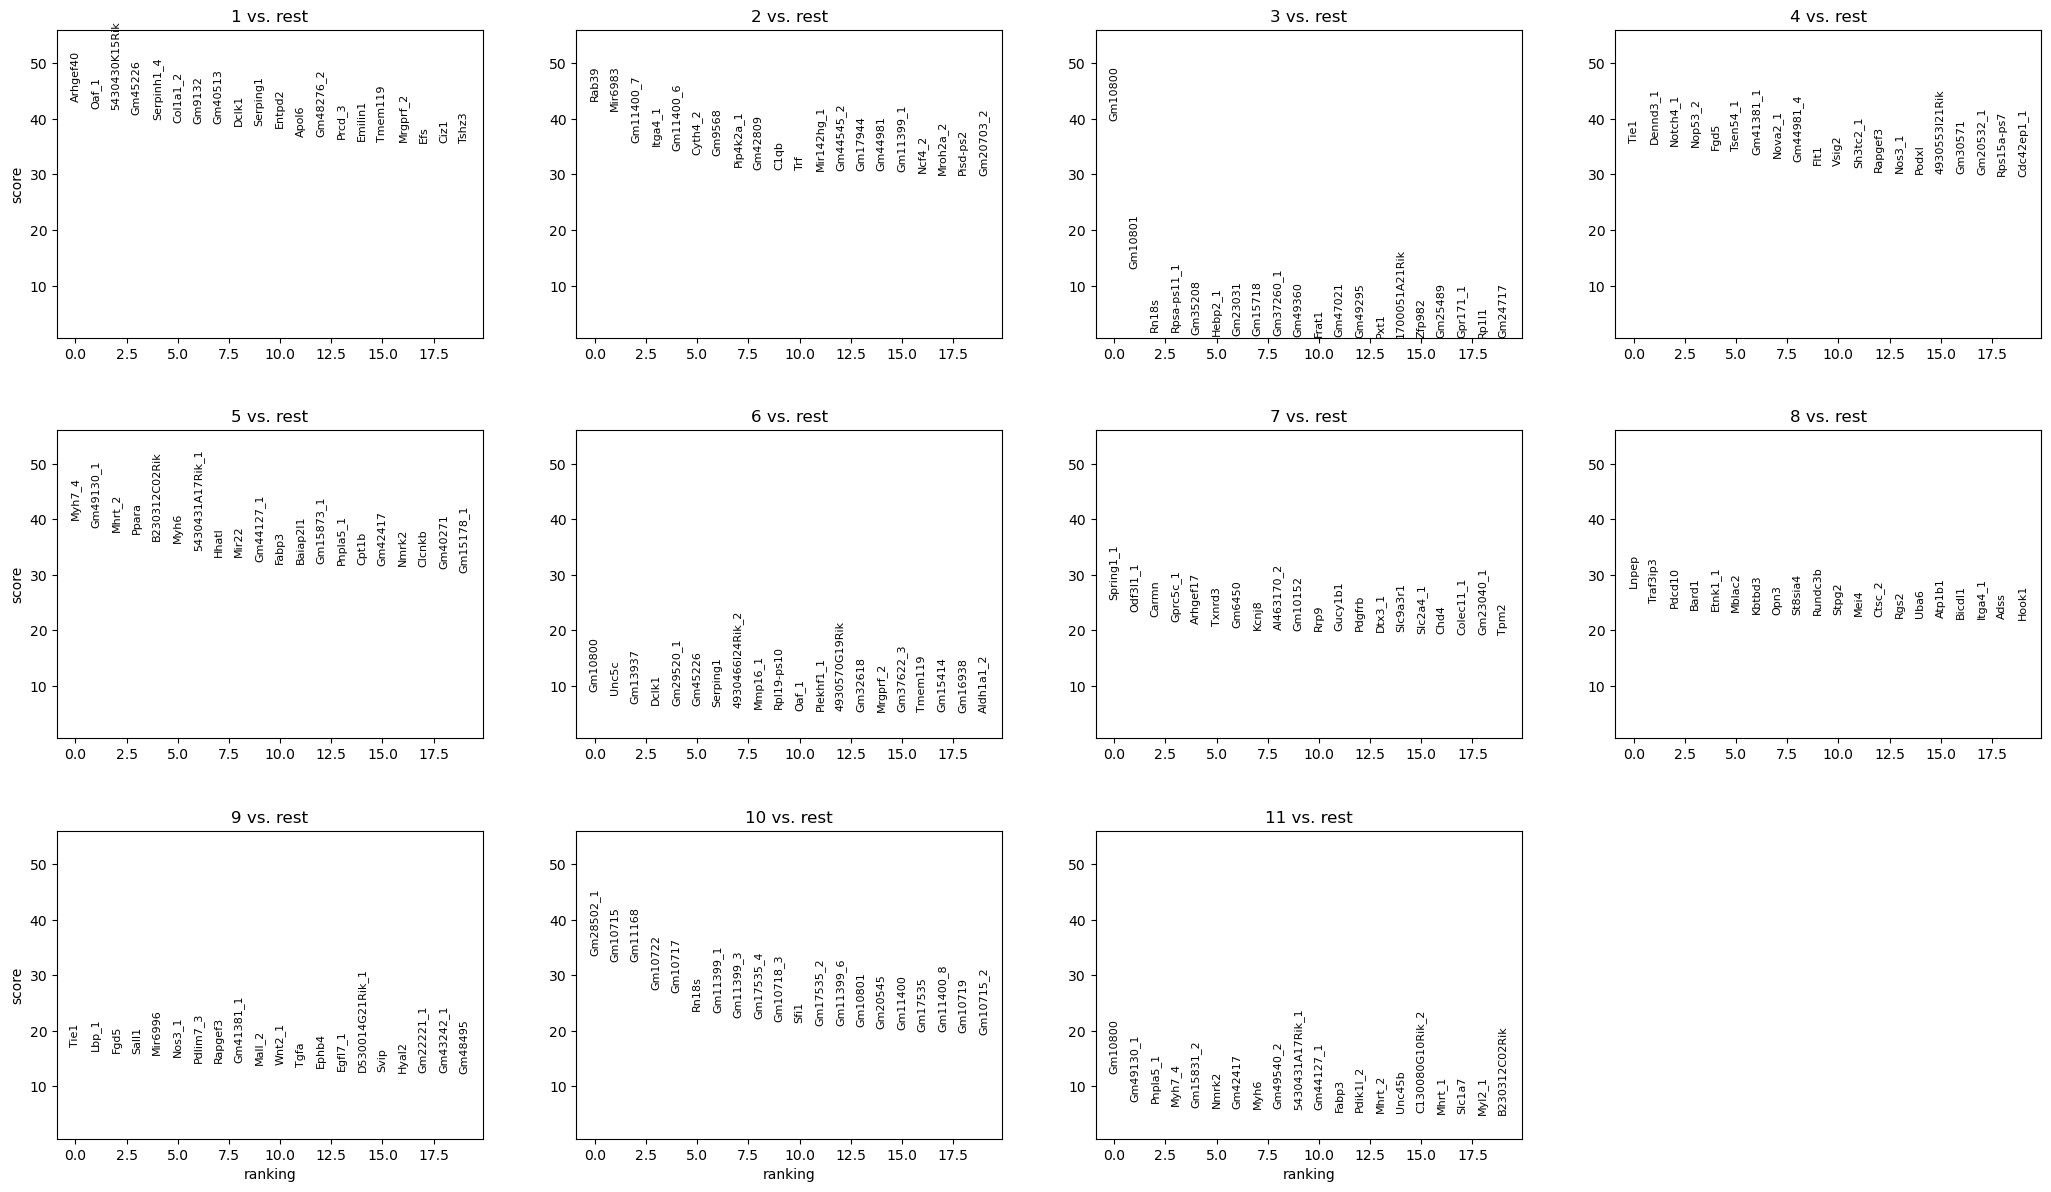

In [51]:
for column in RESOLUTIONS:
    print(f'Plotting ranked genes groups for clustering column {column}')
    plot_key = 'rank_genes_groups_' + str(column)
    sc.pl.rank_genes_groups(genes_adata, key=plot_key, show=False)
    # TODO
    # if save_figs:
    #    plt.savefig(f'{OUTPUT_FIGS}/ranked_genes_groups_leiden_{res}.png')
    plt.show()

Plotting matrixplot for clustering column leiden_0.4


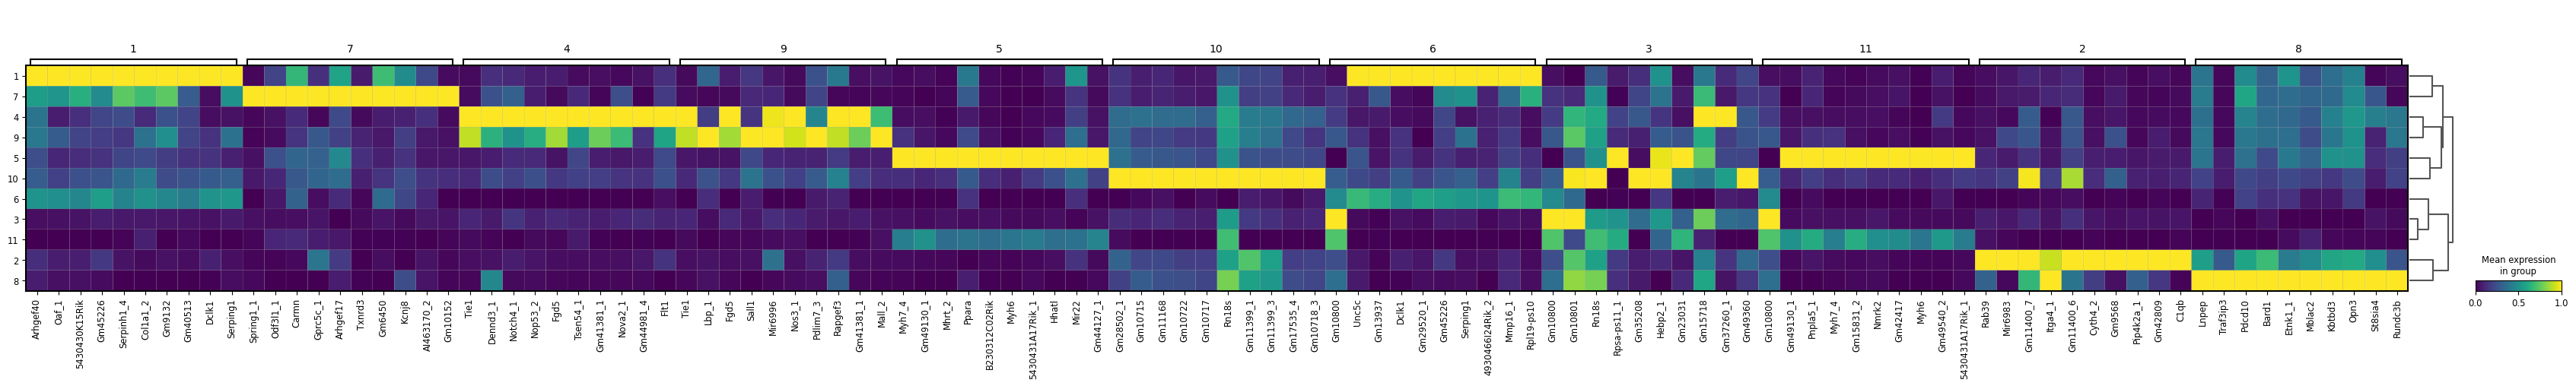

In [52]:
for column in RESOLUTIONS:
    print(f'Plotting matrixplot for clustering column {column}')
    plot_key = 'rank_genes_groups_' + str(column)
    sc.pl.rank_genes_groups_matrixplot(genes_adata, standard_scale='var', n_genes=10, key=plot_key, show=False)
    # TODO
    # if save_figs:
    #    plt.savefig(f'{OUTPUT_FIGS}/ranked_genes_groups_matrixplot_leiden_{res}.png')
    plt.show()

## Cell type annotation

In [53]:
for column in RESOLUTIONS:
    ctannot.annot_ct(adata=adata, genes_adata=genes_adata, output_path=tree.annotation_dir, 
                     db_path=f"{PANGLAO_DB_PATH}", cluster_path=None, cluster_column=f"{column}", 
                     rank_genes_column=f"rank_genes_groups_{column}", sample=tree.run, 
                     ct_column=f"cell_types_{column}", tissue="all", db="panglao", inplace=True, species=SPECIES)

Output folder: /mnt/workspace/jdetlef/ext_ana/processed/all/annotation/ranked/output/leiden_0.4/ 
DB file: /mnt/workspace/jdetlef/panglao_markers 
Cluster folder: /mnt/workspace/jdetlef/ext_ana/processed/all/annotation/ranked/clusters/leiden_0.4/ 
Tissue: all 
DB: panglao
Created folder: /mnt/workspace/jdetlef/ext_ana/processed/all/annotation/ranked/clusters/leiden_0.4
Created folder: /mnt/workspace/jdetlef/ext_ana/processed/all/annotation/ranked/output/leiden_0.4
Writing one file per cluster containing gene names and ranked gene scores.
Starting cell type annotation.
/mnt/workspace/jdetlef/ext_ana/processed/all/annotation /mnt/workspace/jdetlef/ext_ana/processed/all/annotation/ranked/output/leiden_0.4 leiden_0.4
The database contains 13226 different genes.          
The input data contains 25284 different genes.          
The genes of the input data overlap with 3457 genes in total, 26.0 percent.
Adding information to the adata object.
Finished cell type annotation! The results are fo

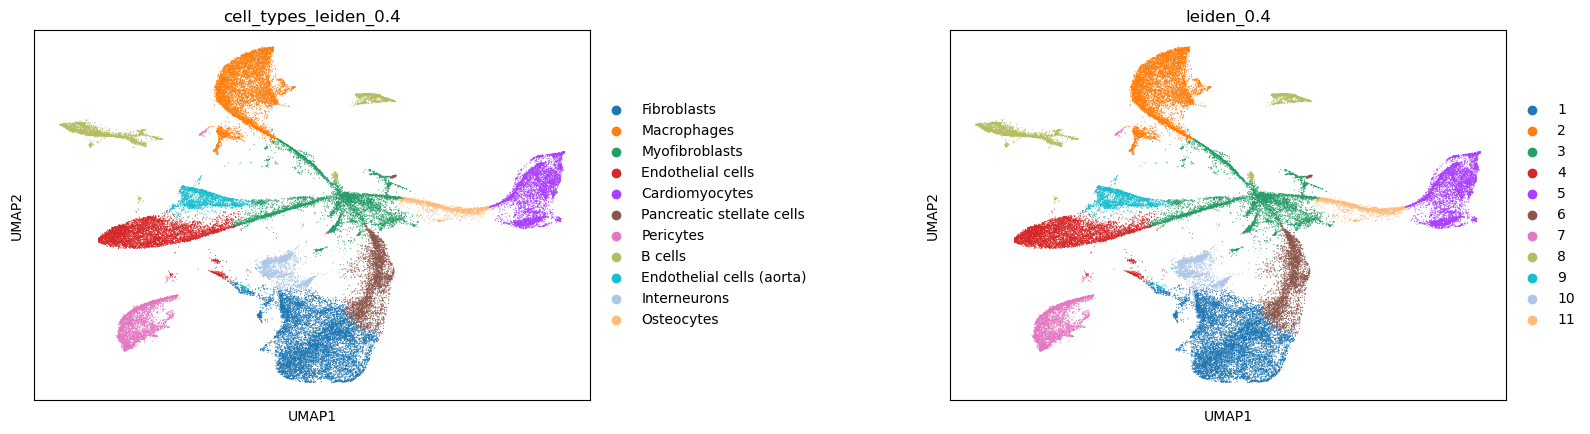

In [54]:
for column in RESOLUTIONS:
    sc.pl.umap(adata, color=[f'cell_types_{column}', f'{column}'], wspace=0.5)

In [55]:
for column in RESOLUTIONS:
    print(f"Tables of cell type annotation with clustering {column}")
    ctannot.show_tables(annotation_dir=tree.annotation_dir, n=5, clustering_column=column)

Tables of cell type annotation with clustering leiden_0.4


,Cluster 10: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Interneurons,364,188,657,10
1,Motor neurons,357,13,39,22
2,Intercalated cells,332,20,75,20
3,Alpha cells,331,35,143,12
4,Urothelial cells,330,9,27,27


,Cluster 2: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Macrophages,1531,131,495,8
1,Red pulp macrophages,1187,11,49,12
2,Kupffer cells,988,35,127,13
3,Microglia,983,71,259,7
4,Langerhans cells,965,11,71,14


,Cluster 3: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Myofibroblasts,-231,9,32,6
1,Spermatozoa,-245,7,27,12
2,Osteocytes,-265,5,18,13
3,Glutaminergic neurons,-270,9,28,10
4,Parathyroid chief cells,-285,7,26,15


,Cluster 8: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,B cells,858,86,322,10
1,T memory cells,596,54,198,6
2,B cells naive,530,44,170,11
3,B cells memory,479,45,172,12
4,T cells,452,77,299,8


,Cluster 1: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Fibroblasts,1585,167,553,8
1,Podocytes,885,89,338,10
2,Trophoblast cells,877,25,78,17
3,Peritubular myoid cells,733,23,63,10
4,Pericytes,706,62,203,9


,Cluster 4: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Endothelial cells,1851,171,600,9
1,Endothelial cells (aorta),1062,85,280,11
2,Clara cells,497,14,85,17
3,Hematopoietic stem cells,446,74,290,8
4,Erythroblasts,359,19,94,7


,Cluster 7: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Pericytes,653,62,203,9
1,Hepatic stellate cells,341,37,149,9
2,Vascular smooth muscle cells,330,6,19,10
3,Mesangial cells,287,51,205,7
4,Enterochromaffin cells,216,7,51,20


,Cluster 6: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Pancreatic stellate cells,-62,26,67,5
1,Vascular smooth muscle cells,-71,6,19,10
2,Noradrenergic neurons,-96,5,20,16
3,Kidney progenitor cells,-128,6,15,20
4,Parathyroid chief cells,-130,7,26,15


,Cluster 11: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Osteocytes,-48,5,18,13
1,Myofibroblasts,-83,9,32,6
2,Glutaminergic neurons,-109,9,28,10
3,Foveolar cells,-114,10,71,12
4,Parathyroid chief cells,-114,7,26,15


,Cluster 9: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Endothelial cells (aorta),676,85,280,11
1,Endothelial cells,521,171,600,9
2,Trophoblast cells,274,25,78,17
3,Clara cells,261,14,85,17
4,Kidney progenitor cells,206,6,15,20


,Cluster 5: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Cardiomyocytes,3795,94,314,15
1,Myocytes,2061,79,269,16
2,Smooth muscle cells,926,72,255,10
3,Interneurons,780,188,657,10
4,Adipocytes,738,102,358,13


### Modify wrong cluster annotations by selecting other recommendations

In [56]:
if MODIFY_CELL_TYPES:
# Pick the cell type column of the obs table you want to modify as well as the corresponding clustering column
    cell_type_column = "cell_types_leiden_0.4"
    clustering_column = "leiden_0.4"

    ctannot.modify_ct(adata=adata, annotation_dir=tree.annotation_dir, clustering_column=clustering_column, 
                      cell_type_column=cell_type_column, inplace=True)

### SCSA cell type annotation

Removing underscores from gene names

In [57]:
genes_adata.var.index = pd.Index([name.split('_')[0] for name in genes_adata.var.index])

Rank new gene names

In [58]:
for column in RESOLUTIONS:
    print(f'Ranking genes groups for clusters using obs column {column}')
    sc.tl.rank_genes_groups(genes_adata, groupby=f'{column}', use_raw=False, key_added=f'rank_genes_groups_SCSA_{column}')

print('Done')

Ranking genes groups for clusters using obs column leiden_0.4
Done


Found 25284 genes from input ranked genes
Checking if genes are in the database...
3447/25284 (13.6%) input genes were found in User DB database (total genes in database: 13224)
3447/13224 (26.1%) of genes in User DB database were used for annotation
Running SCSA...

Done. Best scoring celltype was added to 'SCSA_pred_celltype_leiden_0.4' and the full results were added to adata.uns['SCSA']
Cluster 1 was annotated with celltype: Fibroblasts
Cluster 10 was annotated with celltype: Interneurons
Cluster 11 was annotated with celltype: Cardiomyocytes
Cluster 2 was annotated with celltype: Macrophages
Cluster 4 was annotated with celltype: Endothelial cells
Cluster 5 was annotated with celltype: Cardiomyocytes
Cluster 6 was annotated with celltype: Epithelial cells
Cluster 7 was annotated with celltype: Pericytes
Cluster 8 was annotated with celltype: B cells
Cluster 9 was annotated with celltype: Endothelial cells


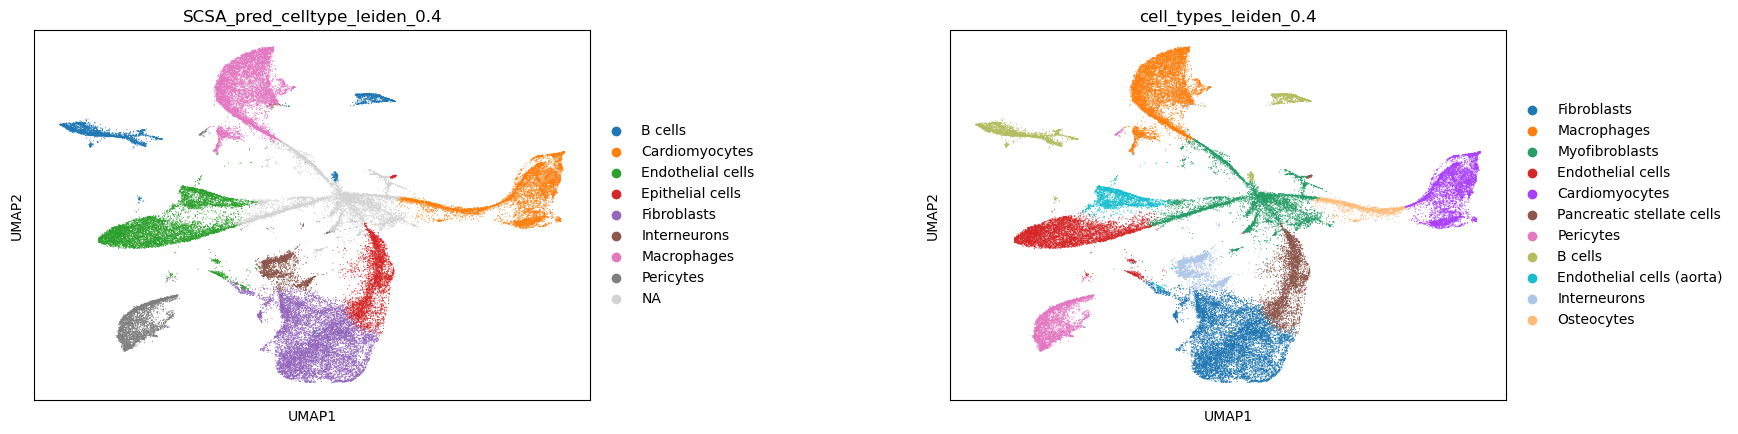

In [59]:
for column in RESOLUTIONS:
    run_scsa(genes_adata,
             gene_column=None,
             gene_symbol='auto',
             key=f'rank_genes_groups_SCSA_{column}',
             column_added=f'SCSA_pred_celltype_{column}',
             inplace=True,
             python_path=None,
             scsa_path=None,
             wholedb_path=None,
             species=None,
             fc=1.5,
             pvalue=0.01,
             tissue='All',
             celltype='normal',
             user_db=SCSA_CUSTOM_DB_PATH,
             z_score='best',
             )
    adata.obs[f'SCSA_pred_celltype_{column}'] = genes_adata.obs[f'SCSA_pred_celltype_{column}']
    sc.pl.umap(adata, color=[f'SCSA_pred_celltype_{column}', f'cell_types_{column}'], wspace=0.5)


## Save notebook and adata object

In [60]:
repo_path = os.getcwd()
notebook_name = '05_annotation.ipynb'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.annotation_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)

'/mnt/workspace/jdetlef/ext_ana/processed/all/annotation/05_annotation.ipynb'

In [61]:
adata_output = tree.annotation_anndata
adata.write(filename=adata_output)